In [1]:
#Import essential library to build model and data processing.
import numpy as np   #NumPy for numerical operations
import pandas as pd #data manipulation and analysis
import os   #os for interacting with the operating system
import cv2   #OpenCV for computer vision and image processing
import glob   # glob for file path expansion
import matplotlib.pyplot as plt   #Matplotlib for data visualization
import sklearn   #scikit-learn for machine learning tools
import seaborn as sns   #stats dv
from sklearn.model_selection import train_test_split  # for the split of the dataset
from sklearn.metrics import roc_curve, auc

In [2]:
#import pytorch lib for deep learning
import torch                                                   # Import PyTorch, a deep learning framework.
import torchvision.transforms as transforms                    # Import transforms module from torchvision for image transformations.
import torchvision                                              # Import torchvision for pre-trained models and datasets.
import torch                                                   # Redundant import, already imported at the beginning.
import torch.nn.functional as F                                 # Import functional interface of neural network operations in PyTorch.
from torch import nn                                            # Import neural network module from PyTorch for building models.
from torchvision import datasets, transforms, models            # Import datasets, transforms, and pre-trained models from torchvision.
from torch import optim                                         # Import PyTorch's optimization module.
from torch.autograd import Variable                              # Import Variable from PyTorch's autograd for automatic differentiation.
import torch.utils.data as data_utils                            # Import data utilities from PyTorch for handling datasets.
from torch.utils.data import DataLoader, Dataset                 # Import DataLoader and Dataset classes for loading and handling data.


In [3]:
#check device is cpu or gpu.
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")   #check CPU is available or the GPU
print(device)

cuda


In [4]:
 #Import the Google Colab drive module for connecting and mounting Google Drive.

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# link from where we can retrived the data  and the extension of the images to usd while create labels.
data = '/content/drive/MyDrive/dataset2'
ext = ['png', 'jpg', 'jpeg']

In [6]:
# we will read image file names and store in list format
image_name = os.listdir(data)#EVERY FILE NAME STORED IN THE LIST
print(len(image_name))
print(image_name[0])# PRINT THE FIRST FILE NAME OF THE LIST.

1125
cloudy239.jpg


In [7]:
#CREATE A LABLE FROM FILE NAME
def generate_label(target, ext):
  '''it will remove the extension of the image and
  numeric values present in image name to create the label'''
  df = pd.DataFrame(target, columns = ['label'])
  for e in ext:
    df['label'] = df['label'].str.rstrip('.' + e)  #REMOVE THE EXT. FROM FILE NAME SUCH AS JPG...
  df['label'] = df['label'].str.replace('\d+', '')
  return df

In [8]:
df_label = generate_label(image_name, ext)

<ipython-input-7-dd54675a6758>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label'] = df['label'].str.replace('\d+', '')


In [9]:
#COVERT THE IMG TO VECTOR FORM IN THE 'DF'.
def get_image(data, image_name):
  '''it will read the images and stored it inside dataframe.'''
  files = []
  [files.extend(glob.glob(data +  '/' + e)) for e in image_name]
  images = [cv2.imread(file) for file in files]
  df_image = pd.DataFrame(images, columns=['image'])
  return df_image

In [10]:
df_image = get_image(data, image_name)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [11]:
# replace the labels with numeric values and indexing start from the 0 and concat the two dataframe in one.
df_label['label'] = df_label['label'].map( {'cloudy':0 , 'shine':1, 'rain':2, 'sunrise':3} )
weather_data = pd.concat([df_image, df_label], axis = 1)
weather_data

,image,label
0,"[[[57, 58, 56], [57, 58, 56], [57, 58, 56], [5...",0
1,"[[[21, 37, 44], [37, 53, 60], [11, 22, 30], [1...",0
2,"[[[98, 98, 98], [98, 98, 98], [98, 98, 98], [9...",0
3,"[[[168, 166, 165], [167, 165, 164], [166, 164,...",0
4,"[[[155, 132, 130], [156, 133, 131], [158, 135,...",0
...,...,...
1120,"[[[55, 55, 55], [55, 55, 55], [55, 55, 55], [5...",0
1121,"[[[189, 189, 189], [65, 65, 65], [66, 66, 66],...",0
1122,"[[[64, 48, 31], [63, 47, 30], [62, 46, 29], [6...",0
1123,"[[[151, 125, 108], [152, 126, 109], [152, 126,...",0


In [12]:
weather_data.isnull().sum()  # null values check

image    2
label    0
dtype: int64

In [13]:
weather_data = weather_data.dropna()   #drop the null values


In [14]:
weather_data.isnull().sum()   # reconformed the null values

image    0
label    0
dtype: int64

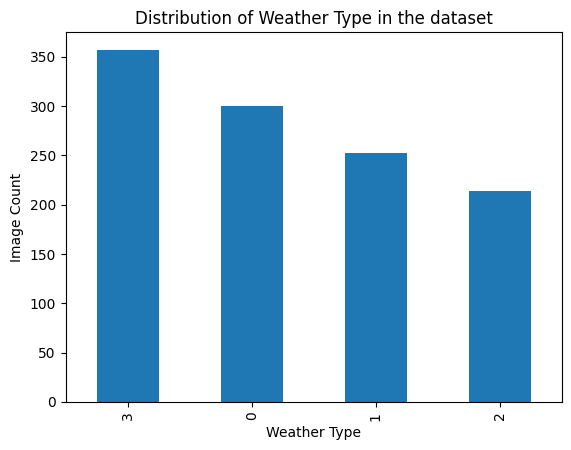

In [15]:
#distribution of the weather data in four categories ('cloudy':0 , 'shine':1, 'rain':2, 'sunrise':3)
ax = weather_data['label'].value_counts().plot(kind='bar')
ax.set_xlabel("Weather Type")
ax.set_ylabel("Image Count")
ax.title.set_text("Distribution of Weather Type in the dataset")

In [16]:
#train test validation
train_data, test_data = train_test_split(weather_data,test_size=0.1)
train_data, valid_data = train_test_split(train_data,test_size=0.15)
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(858, 2)
(152, 2)
(113, 2)


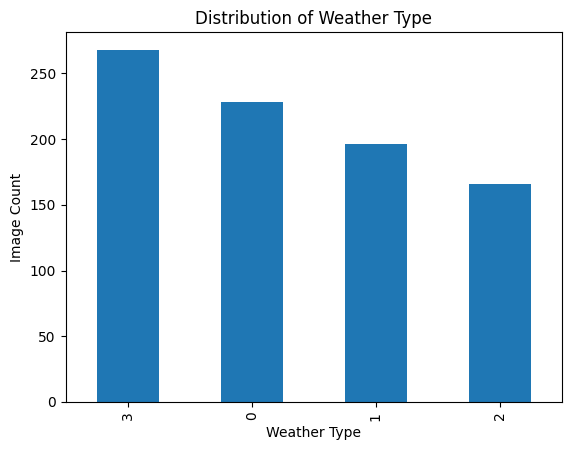

In [17]:
ax = train_data['label'].value_counts().plot(kind='bar')
ax.set_xlabel("Weather Type")
ax.set_ylabel("Image Count")
ax.title.set_text("Distribution of Weather Type")

In [18]:
image_aug = train_data[train_data['label'] == 2]#image augmentation

In [19]:
#flip the image augmentation
def image_augmentation(dataframe):
  for i in range (len(dataframe.index)):
    dataframe.image.iloc[i] = cv2.flip(dataframe.image.iloc[i], 1)
  return dataframe

In [20]:
data_image_augment = image_augmentation(image_aug)

<ipython-input-19-0101182b691e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.image.iloc[i] = cv2.flip(dataframe.image.iloc[i], 1)


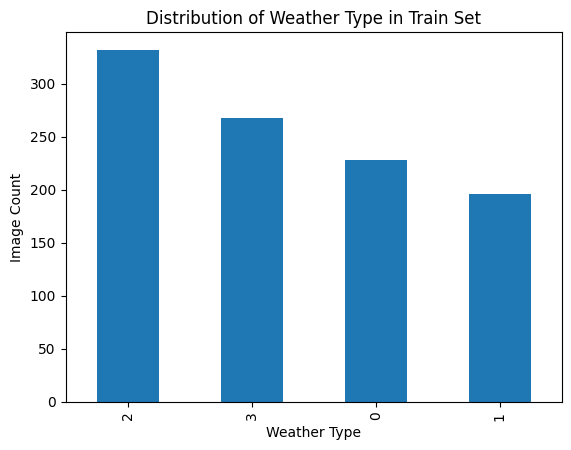

In [21]:
train_data_aug = pd.concat([train_data, data_image_augment])
ax = train_data_aug['label'].value_counts().plot(kind='bar')
ax.set_xlabel("Weather Type")
ax.set_ylabel("Image Count")
ax.title.set_text("Distribution of Weather Type in Train Set")

In [22]:
#create dic for image and it's label
class ImageDataset(Dataset):
  def __init__(self, dataframe, transform):
    self.dataframe = dataframe
    self.transform=transform
    self.image=self.dataframe['image']
    self.labels=np.array(self.dataframe['label'])

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,index):

    image=self.transform(self.image.iloc[index])
    targets=self.labels[index]
    sample = {'image': image,'labels':targets}
    return sample

In [23]:
#image convert into tensor[n dimentional array and use resize finction to convert all the image into shape apply diff transformation technique in train data]
train_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomRotation(degrees=45),
                transforms.ColorJitter(),
                transforms.ToTensor()])

valid_transform =transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor()])

test_transform =transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor()])

train_dataset=ImageDataset(train_data_aug, train_transform)
valid_dataset=ImageDataset(valid_data, valid_transform)
test_dataset=ImageDataset(test_data, test_transform)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=True
)

import torch.nn as nn

# Create a sequential model
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(64 * 28 * 28, 512),
    nn.ReLU(),
    nn.Linear(512, num_classes)  # Assuming `num_classes` is defined somewhere
)

# Print the model architecture
print(model)


In [24]:
#simple  cnn model 2d cov layer
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):   # def classes i have 4 classes rain, shine, sunrise, cloudy.
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   #  Convolutional Layer 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  #  Convolutional Layer 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  #  Convolutional Layer 3
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)          # MaxPooling Layer

        self.fc1 = nn.Linear(64 * 28 * 28, 512)    #Fully Connected Layer 1
        self.fc2 = nn.Linear(512, num_classes)     # fully connected Layer 2  (classes of my prediction)

    def forward(self, x):       # for all 3 layers ReLU actiovation function.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Instantiate the model
model = SimpleCNN()

# Print the model architecture
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


In [25]:
model = SimpleCNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 3e-5)
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

model.parameters(): This provides the parameters (weights and biases) of the model to the optimizer. The optimizer will update these parameters during training to minimize the loss.

lr=0.0001: This sets the learning rate, which determines the step size the optimizer takes during parameter updates. A smaller learning rate can lead to more precise updates but may require more training iterations.

weight_decay=3e-5: This introduces L2 regularization by adding a penalty term to the loss function proportional to the square of the weights. It helps prevent overfitting by discouraging overly complex models.

In [26]:
def fit(n_epochs,
        model,
        device,
        train_loader,
        valid_loader,
        criterion,
        optimizer):
    '''It will perform model training and validation.'''
    epochs = n_epochs
    history = []
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        running_loss = 0
        valid_loss = 0
        train_acc = 0
        valid_acc = 0

        # Model Training
        for sample in train_loader:
            images = sample['image']
            labels = sample['labels']
            # data and target value on device either a CPU or GPU.
            images = images.to(device=device, dtype = torch.float)
            labels = labels.to(device=device, dtype = torch.long)
            # Clear gradients
            optimizer.zero_grad()
            # Predicted images outputs
            outputs = model(images)
            #calculate the loss between prediction and target values
            loss = criterion(outputs, labels)
            #backpropogation of gradients
            loss.backward()
            #update the parameter
            optimizer.step()
            # Store the loss in variable
            running_loss += loss.item()
            # model's prediction using the max probability
            _, pred = torch.max(outputs, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            #convert the tensor
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            #track the accuracy
            train_acc += accuracy.item()

        # Validation Model
        # Don't need to keep track of gradients
        with torch.no_grad():
            # set model to evaluate model
            model.eval()
            for sample in valid_loader:
                images = sample['image']
                labels = sample['labels']
                # data and target on deivece and datatype decision
                images = images.to(device=device, dtype = torch.float)
                labels = labels.to(device=device, dtype = torch.long)
                #prediction of the model
                output = model(images)
                #calculate valid loss
                valid_loss += criterion(output, labels)
                #calculate the accuracy and convert the type
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(labels.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                #calculate accuracy to keet track
                valid_acc += accuracy.item()
            #store loss and accuracy in list
            history.append([running_loss /
                            len(train_loader), train_acc /
                            len(train_loader), valid_loss /
                            len(valid_loader), valid_acc /
                            len(valid_loader), epoch])
            # save the model if valid loss decrease
            if valid_loss <= valid_loss_min:
                torch.save(model.state_dict(), 'best_model_weather.pth')
                valid_loss_min = valid_loss
    return model, history

In [27]:
model, history = fit(10, model, device, train_dataloader, valid_dataloader, criterion, optimizer)

In [28]:
train_history = pd.DataFrame(history, columns = ['train_loss', 'train_acc', 'valid_loss', 'valid_acc', 'epoch'])

In [29]:
def training_loss_performance(dataframe: pd.DataFrame):
    '''It used the history generated from the training to plot the train vs valid loss.'''
    plt.plot(dataframe['epoch'], dataframe['train_loss'], 'r', label='Training loss')
    plt.plot(dataframe['epoch'], dataframe['valid_loss'], 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

def train_acc_performance(dataframe: pd.DataFrame):
    '''It used the history generated from the training to plot the train vs valid accuracy.'''
    plt.plot(dataframe['epoch'], dataframe['train_acc'], 'r', label='Training acc')
    plt.plot(dataframe['epoch'], dataframe['valid_acc'], 'b', label='Validation acc')
    plt.title('Training and Validation Accurac for simple cnn')
    plt.legend()
    plt.show()

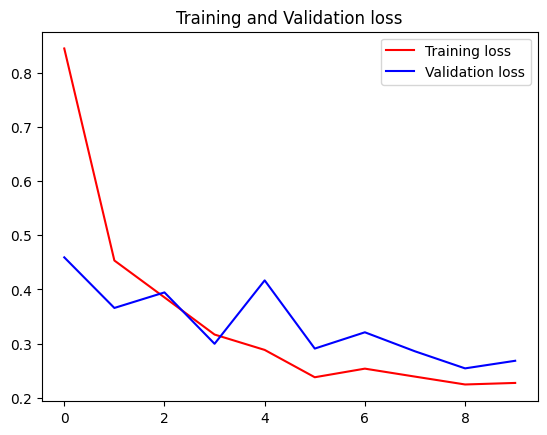

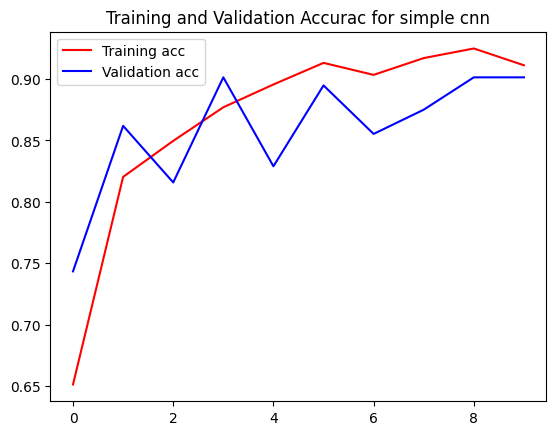

In [30]:
training_loss_performance(train_history)
train_acc_performance(train_history)

In [31]:
def evaluation(device,
               model,
               test_loader):
    '''It will perform model testing and store the actual target and predicted result into list.'''
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for sample in test_loader:
            images = sample['image']
            labels = sample['labels']
            images = images.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)
            output = model(images)
            _, output = torch.max(output, dim=1)
            fin_targets.extend(labels.cpu().detach().numpy().tolist())
            fin_outputs.extend(output.cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [32]:
outputs, targets = evaluation(device, model, test_dataloader)

In [33]:
print(sklearn.metrics.classification_report(outputs, targets))

              precision    recall  f1-score   support

           0       0.74      0.86      0.79        29
           1       0.97      0.77      0.86        39
           2       0.85      1.00      0.92        17
           3       0.96      0.96      0.96        28

    accuracy                           0.88       113
   macro avg       0.88      0.90      0.88       113
weighted avg       0.89      0.88      0.88       113



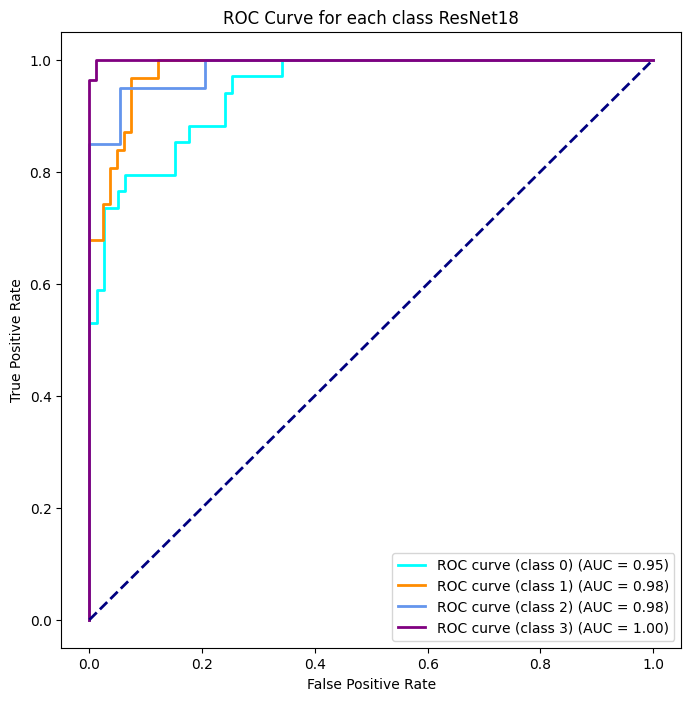

In [39]:
model.eval()  # print the roc-auc curve for the each class so here we have the 4 classes

all_labels = []
all_probs = []


with torch.no_grad():
    for sample in test_dataloader:
        images = sample['image'].to(device)
        labels = sample['labels'].to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 4   # give the number of the classes


from sklearn.preprocessing import label_binarize
all_labels_binarized = label_binarize(all_labels, classes=range(num_classes))


for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 8))

# Define colors for each class
colors = ['aqua', 'darkorange', 'cornflowerblue', 'purple'][:num_classes]

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class ResNet18')
plt.legend(loc='lower right')
plt.show()


In [40]:
ckpt = torch.load('best_model_weather.pth')

In [41]:
def imshow(image, ax=None, title=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

tensor([0], device='cuda:0')


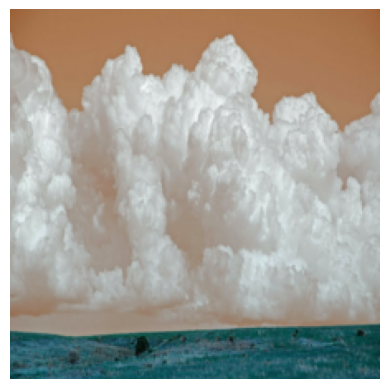

In [42]:
sample = next(iter(test_dataloader))
images = sample['image']
targets = sample['labels']
a1 = imshow(images[0])
images, labels = images.to(device), targets.to(device)
img = images[0].view(1,3,224,224)

with torch.no_grad():
    model = model.to(device)
    logits = model(img)

_, output = torch.max(logits, dim=1)
print(output)
